<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [3]:
import os

import phik
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set(
    style='darkgrid'
)

In [6]:
person_df = pd.read_csv('./datasets/insurance.csv')

# выводим случайные пять строк датасета
person_df.sample(5)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
979,0,45.0,39900.0,0,1
2627,1,39.0,22500.0,0,0
3466,0,22.0,32700.0,4,0
953,1,18.0,38800.0,1,0
454,0,27.0,27700.0,1,0


In [7]:
# придерживаемся pythonic way
pythonic_names = {
    'Пол': 'sex',
    'Возраст': 'age',
    'Зарплата': 'salary',
    'Члены семьи': 'family_members',
    'Страховые выплаты': 'insurance_payments'
}

person_df = person_df.rename(columns=pythonic_names)

In [8]:
# выведем основную информацию
person_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   salary              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_payments  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Как видим, во всех колонках нет отсутствующих значений. Посмотрим на количество уникальных значений в колонках `Пол`, `Члены семьи` и `Страховые выплаты`.

In [9]:
cols = ['sex', 'family_members', 'insurance_payments']

print('Число уникальных значений в колонке')
for col in cols:
    print(f'{col:>20}:', person_df[col].nunique())

Число уникальных значений в колонке
                 sex: 2
      family_members: 7
  insurance_payments: 6


По идее, максимальные числа в рассматриваемых колонках должны отличаться на единицу от числа уникальных значений, проверим это. 

In [10]:
print('максимальное число в колонке')
for col in cols:
    print(f'{col:>20}:', person_df[col].unique().max())

максимальное число в колонке
                 sex: 1
      family_members: 6
  insurance_payments: 5


In [11]:
# преобразуем типы данных в колонках
for dtype, col in zip(['bool', 'uint8', 'uint8'], cols):
    person_df[col] = person_df[col].astype(dtype)

In [12]:
# посмотрим, есть ли полностью повторяющиеся строки
person_df.duplicated().sum()

153

In [13]:
person_df[person_df.duplicated(keep=False)].sort_values(['salary']).head(6)

,sex,age,salary,family_members,insurance_payments
2955,True,32.0,21600.0,0,0
2988,True,32.0,21600.0,0,0
361,False,50.0,24700.0,1,2
2869,False,50.0,24700.0,1,2
333,False,32.0,25600.0,1,0
4230,False,32.0,25600.0,1,0


In [14]:
# удалим дубликаты
person_df = person_df.drop_duplicates()
person_df = person_df.reset_index(drop=True).round(1)

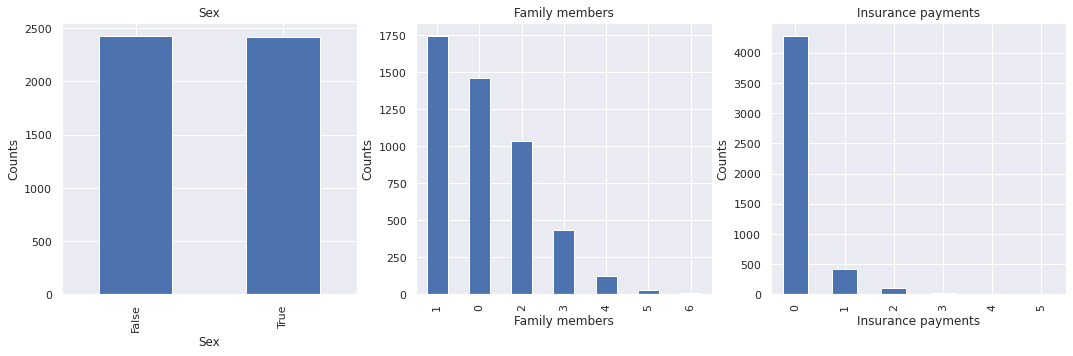

In [15]:
# построим гистограммы для номинативных признаков и признаков с целыми числами
fig = plt.figure(figsize=(18, 5))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i + 1)
    person_df[col].value_counts().plot(kind='bar')
    
    plt.title(col.replace('_', ' ').capitalize())
    plt.xlabel(col.replace('_', ' ').capitalize())
    plt.ylabel('Counts')
    
plt.show()

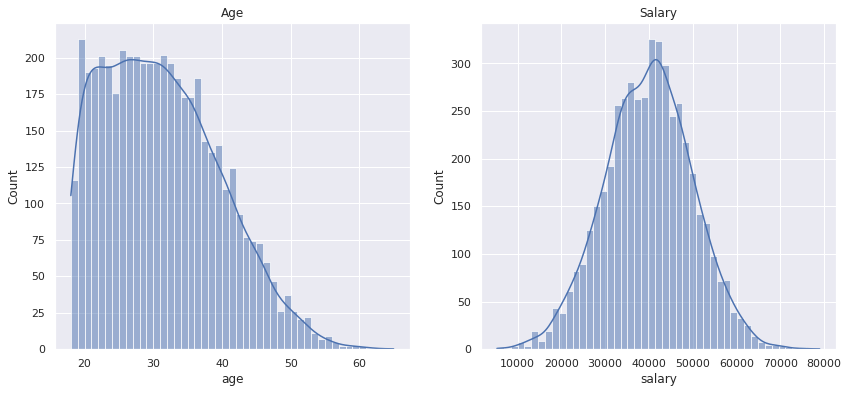

In [16]:
# построим гистограммы и распределения плотностей вероятности для остальных признаков
fig = plt.figure(figsize=(14, 6))

for i, col in enumerate(['age', 'salary']):
    plt.subplot(1, 2, i + 1)
    sns.histplot(person_df, x=col, kde=True, bins=47)
    plt.title(col.capitalize())
    
plt.show()

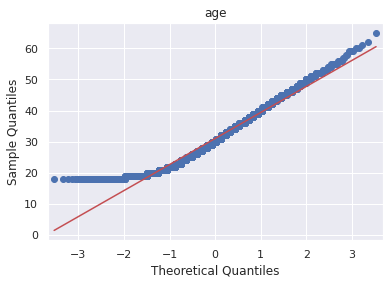

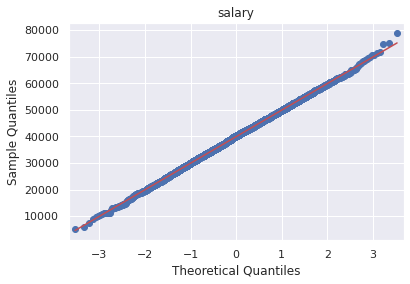

In [17]:
# построим QQ-график для определения "нормальности" распределений значений численных признаков
for col in person_df.select_dtypes(['float']):
    sm.qqplot(person_df[col], line='r');
    plt.title(col)

Из представленных графиков видно, что точки в случае `salary` почти идеально ложатся на прямую линию, что говорит о нормальности распределения значений данного признака. В случае `age` явно видно, что распределение не нормальное (что можно было заметить и без QQ-графика).

In [18]:
# выведем описательную статистику для численных признаков
person_df.describe()

,age,salary,family_members,insurance_payments
count,4847.000000,4847.000000,4847.000000,4847.000000
mean,31.023932,39895.811842,1.203425,0.152259
std,8.487995,9972.953985,1.098664,0.468934
min,18.000000,5300.000000,0.000000,0.000000
25%,24.000000,33200.000000,0.000000,0.000000
50%,30.000000,40200.000000,1.000000,0.000000
75%,37.000000,46600.000000,2.000000,0.000000
max,65.000000,79000.000000,6.000000,5.000000


In [19]:
# посмотрим на корреляцию численных признаков используя коэффициент корреляции Пирсона
person_df[['age', 'salary']].corr(numeric_only=True).style.background_gradient(cmap='YlOrRd')

,age,salary
age,1.000000,-0.017386
salary,-0.017386,1.000000


In [20]:
# посмотрим на корреляцию признаков используя коэффициент phi_k
person_df.phik_matrix().style.background_gradient(cmap='YlOrRd')

interval columns not set, guessing: ['age', 'salary', 'family_members', 'insurance_payments']


,sex,age,salary,family_members,insurance_payments
sex,1.000000,0.000000,0.000000,0.000000,0.035338
age,0.000000,1.000000,0.065398,0.000000,0.884910
salary,0.000000,0.065398,1.000000,0.000000,0.000000
family_members,0.000000,0.000000,0.000000,1.000000,0.000000
insurance_payments,0.035338,0.884910,0.000000,0.000000,1.000000


### Вывод

- проведена загрузка и предобработка данных:
    - удалены дубликаты
    - данные приведены к соответствующим типам
    - пропусков не обнаружено
- число записей, относящихся к женщинам и мужчинам - одинаковое
- распределения значений для колонки `salary` - нормальное, для `age` - ненормальное
- признаки линейно независимы. Это важно, ведь иначе мы не смогли бы найти псевдообратную матрицу при обучении линейной регрессии.
- наблюдается высокая корреляция между целевым признаком и возрастом клиента.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

**Ответ:** Не изменится.

**Обоснование:** Пусть $P$ - обратимая матрица. По условию: 
$$\hat{a}=\hat{X}\hat{w}=XP\hat{w}$$

Запишем формулу обучения для модели с измененными признаками, принимая во внимание, что $(AB)^T=B^TA^T$:
$$\hat{w}=(\hat{X}^T\hat{X})^{-1}\hat{X}^Ty=((XP)^T XP)^{-1}(XP)^Ty=(P^TX^TXP)^{-1}P^TX^Ty$$

Важно не забывать, что обратная матрица вычисляется **только для квадратных** матриц. Принимая также во внимание, что $(AB)^{-1}=B^{-1}A^{-1}$, раскроем скобку:
$$\hat{w}=P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty$$

Умножение матрицы на обратную ей матрицу дает единичную матрицу, т.е. $(P^T)^{-1}P^T=E$, тогда мы получим:
$$\hat{w}=P^{-1}(X^TX)^{-1}X^Ty=P^{-1}w$$

Таким образом, мы нашли связь $\hat{w}$ и $w$. Далее подставлем полученный результат в формулу для $\hat{a}$:
$$\hat{a}=XP\hat{w}=XPP^{-1}w=Xw=a$$
Что и требовалось доказать.

## Алгоритм преобразования

**Алгоритм**

1. Генерация квадратной обратимой матрицы преобразований
2. Проверка, что матрица действительно обратима
3. Умножение матрицы признаков на матрицу преобразований
4. Обучение модели на новых признаках

**Обоснование**

Пусть матрица признаков $X$ имеет размерность $m\times n$. Для того, чтобы матрица $P$ была обратимой, она должна быть квадратной и невырожденной, т.е. её определитель не должен равняться нулю. Чтобы была возможность провести скалярное произведение $XP$, размерность матрицы $P$ должна быть $n\times n$.

К генерации обратимой матрицы можно подойти по-разному. Например:
1. Генерируем случайную матрицу. Проверяем, что определитель не равен нулю. Если условие не удовлетворяется, повторяем до тех пор, пока определитель сгенерированной матрицы не будет равняться нулю.
2. Воспользуемся свойством матрицы со строгим диагональным преобладнием - она невырождена. Строгое диагональное преобладание значит, что:
$$\forall i \in \{1,\ ...\ n\}, |a_{ii}| > \sum_{j \ne i} a_{ji}$$
Таким образом, можно сгенерировать случайную матрицу, затем сумму строк присвоить соответсвующим диагональным элементам. При таком алгоритме генерации диагональных элементов есть один случай, когда матрица будет не со строгим диагональным преобладанием: если в первоначально сгенерированной матрице на диагонали стоял ноль. Нужно иметь это ввиду.  

## Проверка алгоритма

Создадим функцию генерации матрицы преобразований $P$, включающих в себя два способа, описанных выше.

In [21]:
def generate_matrix(n: int, method: int = 2) -> np.ndarray:
    """
    Генерация невырожденной квадратной матрицы n x n.
    
    Parameters:
    ----------
    n: int
        размерность квадратной матрицы
    method: int (default 2)
        метод генерации невырожденной матрицы
        
    Returns:
    -------
    matrix (n x n)
    """
    
    if method == 1:
        while True:
            p = np.random.rand(n, n)
            
            if np.linalg.det(p) != 0:
                return p
            
    elif method == 2:
        p = np.random.rand(n, n)
        diag = np.sum(np.abs(p), axis=1) + 1  # обеспечиваем строгое диагональное преобладание
        np.fill_diagonal(p, diag)
        return p

In [22]:
# разделим данные на обучающую и тестовую выборки
X = person_df.drop('insurance_payments', axis=1)
y = person_df.insurance_payments

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=101)

In [23]:
# проверим все размерности выборок
for name, samples in {'train': [X_train, y_train], 'test': [X_test, y_test]}.items():
    print(f'Размерность {name} выборок')
    print('X:', samples[0].shape)
    print('y:', samples[1].shape)

Размерность train выборок
X: (3635, 4)
y: (3635,)
Размерность test выборок
X: (1212, 4)
y: (1212,)


In [24]:
# проведем обучение модели на неизмененных данных
base_model = LinearRegression()
base_model.fit(X_train, y_train)

# выведем score на тестовой выборке
res = pd.DataFrame({'R2': r2_score(y_test, base_model.predict(X_test))}, index=['base model'])
res

,R2
base model,0.423926


In [25]:
# сгенерируем матрицу преобразования по первому методу
p_1 = generate_matrix(X.shape[1], method=1) 

# скалярно перемножим с признаками
X_transformed_1 = pd.DataFrame(X.values @ p_1, columns=X.columns)

# разобьем на train и test
X_trnsf_train_1, X_trnsf_test_1, y_trnsf_train_1, y_trnsf_test_1 = train_test_split(X_transformed_1, y, test_size=0.25, 
                                                                                    shuffle=True, random_state=101)

In [26]:
# взглянем как выглядят преобразованные данные
X_trnsf_train_1.head()

,sex,age,salary,family_members
312,23838.36875,13152.452332,12254.620829,1500.600391
2599,25296.501716,13957.79955,13007.714518,1594.819306
4049,22890.663997,12630.286084,11766.697071,1441.451395
4744,41916.568197,23126.251345,21526.135929,2629.030516
2437,36449.61281,20109.735872,18736.993218,2293.594062


Идеально, теперь ничего непонятно, особенно если переименовать названия колонок в нечто бессмысленное.

In [27]:
# обучаем модель на новых данных
model_1 = LinearRegression()
model_1.fit(X_trnsf_train_1, y_trnsf_train_1)

# добавляем результат в таблицу
res.loc['model 1'] = r2_score(y_trnsf_test_1, model_1.predict(X_trnsf_test_1))

In [28]:
# сгенерируем матрицу преобразования по второму методу
p_2 = generate_matrix(X.shape[1], method=2) 
X_transformed_2 = pd.DataFrame(X.values @ p_2, columns=X.columns)

X_trnsf_train_2, X_trnsf_test_2, y_trnsf_train_2, y_trnsf_test_2 = train_test_split(X_transformed_2, y, test_size=0.25, 
                                                                                    shuffle=True, random_state=101)

In [29]:
# обучаем
model_2 = LinearRegression()
model_2.fit(X_trnsf_train_2, y_trnsf_train_2)

res.loc['model 2'] = r2_score(y_trnsf_test_2, model_2.predict(X_trnsf_test_2))

In [30]:
# выводим сводный результат
res.style.format(precision=15)

,R2
base model,0.423925731692232
model 1,0.423925731692308
model 2,0.423925731692212


Различие только за 10м знаком, преобразование работает корректно.

In [31]:
# функция для восстановления исходных значений
def restore(transformed_X, p_matrix):
    restored = pd.DataFrame(
                            transformed_X.values @ np.linalg.inv(p_matrix), 
                            columns=transformed_X.columns,
                            dtype='float'  # если сразу привести к исходным типам данных могут возникнуть неточности
                           )
    restored = restored.abs().round()
    return restored.astype(X.dtypes)

In [32]:
# восстанавливаем исходные значения признаков
restored_1 = restore(X_transformed_1, p_1)
restored_2 = restore(X_transformed_2, p_2)

In [33]:
# проверяем равенство значений в исходной и восстановленной таблицах
print(X.equals(restored_1))
print(X.equals(restored_2))

True
True


Данные восстановлены корректно.

## Вывод

- В процессе работы с данными они были загружены, предобработаны. Были выявлены основные закономерности.
- Мы доказали, что умножение исходных признаков на обратимую матрицу не изменяет качество модели (как аналитически, так и практически).
- Мы предложили и реализвали алгоритм преобразования.

Таким образом мы показали, что применяя простое скалярное умножение матрицы признаков на обратимую матрицу можно зашифровать данные, при этом их также можно легко восстановить.